# Fine-tuning a Torch object detection model

<a id="try-anyscale-quickstart-torch_detection" href="https://www.anyscale.com/ray-on-anyscale?utm_source=ray_docs&utm_medium=docs&utm_campaign=torch_detection">
    <img src="../../../_static/img/run-on-anyscale.svg" alt="try-anyscale-quickstart">
</a>
<br></br>

This tutorial explains how to fine-tune `fasterrcnn_resnet50_fpn` using the Ray AI libraries for parallel data ingest and training.

Here's what you'll do:
1. Load raw images and [VOC-style](http://host.robots.ox.ac.uk/pascal/VOC/) annotations into a Dataset
2. Fine-tune `fasterrcnn_resnet50_fpn` (the backbone is pre-trained on ImageNet)
3. Evaluate the model's accuracy

You should be familiar with [PyTorch](https://pytorch.org/) before starting the
tutorial. If you need a refresher, read PyTorch's
[training a classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
tutorial.

## Before you begin

* Install the dependencies for Ray Data and Ray Train.

In [14]:
!pip install 'ray[data,train]'

* Install `torch`, `torchmetrics`, `torchvision`, and `xmltodict`.

In [2]:
!pip install torch torchmetrics torchvision xmltodict

## Create a `Dataset`

You'll work with a subset of [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) that contains cats and dogs (the full dataset has 20 classes).

In [15]:
CLASS_TO_LABEL = {
    "background": 0,
    "cat": 1,
    "dog": 2,
}

The dataset contain two subdirectories: `JPEGImages` and `Annotations`. `JPEGImages` contains raw images, and
`Annotations` contains XML annotations.

```
AnimalDetection
├── Annotations
│   ├── 2007_000063.xml
│   ├── 2007_000528.xml
│   └──  ...
└── JPEGImages
    ├── 2007_000063.jpg
    ├── 2007_000528.jpg
    └──  ...
```

### Define a custom datasource

Each annotation describes the objects in an image.

For example, view this image of a dog:

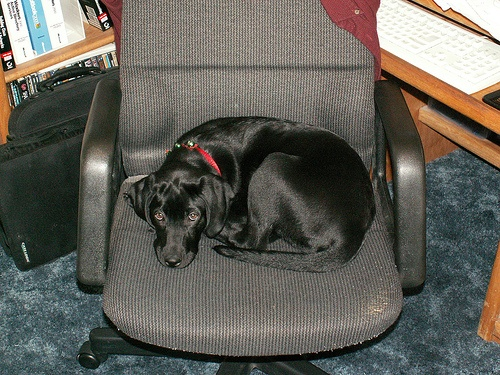

In [16]:
import io

from PIL import Image
import requests

response = requests.get("https://s3-us-west-2.amazonaws.com/air-example-data/AnimalDetection/JPEGImages/2007_000063.jpg")
image = Image.open(io.BytesIO(response.content))
image

Then, print the image's annotation:

In [17]:
!curl "https://s3-us-west-2.amazonaws.com/air-example-data/AnimalDetection/Annotations/2007_000063.xml"

<?xml version="1.0" encoding="utf-8"?>
<annotation>
	<folder>VOC2012</folder>
	<filename>2007_000063.jpg</filename>
	<source>
		<database>The VOC2007 Database</database>
		<annotation>PASCAL VOC2007</annotation>
		<image>flickr</image>
	</source>
	<size>
		<width>500</width>
		<height>375</height>
		<depth>3</depth>
	</size>
	<segmented>1</segmented>
	<object>
		<name>dog</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>123</xmin>
			<ymin>115</ymin>
			<xmax>379</xmax>
			<ymax>275</ymax>
		</bndbox>
	</object>
</annotation>

Notice how there's one object labeled "dog"

```
<name>dog</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<difficult>0</difficult>
<bndbox>
        <xmin>123</xmin>
        <ymin>115</ymin>
        <xmax>379</xmax>
        <ymax>275</ymax>
</bndbox>
```

[Ray Data](data) lets you read and preprocess data in parallel. Ray Data doesn't
have built-in support for VOC-style annotations, so you'll need to define some custom logic to parse the annotations.

In [18]:
from typing import Any, Dict, List, Tuple

import xmltodict


def decode_annotation(row: Dict[str, Any]) -> Dict[str, Any]:
    text = row["bytes"].decode("utf-8")
    annotation = xmltodict.parse(text)["annotation"]

    objects = annotation["object"]
    # If there's one object, `objects` is a `dict`; otherwise, it's a `list[dict]`.
    if isinstance(objects, dict):
        objects = [objects]

    boxes: List[Tuple] = []
    for obj in objects:
        x1 = float(obj["bndbox"]["xmin"])
        y1 = float(obj["bndbox"]["ymin"])
        x2 = float(obj["bndbox"]["xmax"])
        y2 = float(obj["bndbox"]["ymax"])
        boxes.append((x1, y1, x2, y2))

    labels: List[int] = [CLASS_TO_LABEL[obj["name"]] for obj in objects]

    filename = annotation["filename"]

    return {
        "boxes": boxes,
        "labels": labels,
        "filename": filename,
    }


### Read annotations

To load the annotations into a `Dataset`, call `ray.data.read_binary_files` to read the annotation bytes and `map` to decode the annotations. Ray Data reads and parses the annotations in parallel.

In [19]:
import os
import ray


path = "s3://anonymous@air-example-data/AnimalDetection/Annotations"
annotations: ray.data.Dataset = (
    ray.data.read_binary_files(path)
    .map(decode_annotation)
)

Look at the first two samples. Ray Data should've correctly parsed labels and bounding boxes.

In [8]:
annotations.take(2)

2025-03-10 13:36:23,842	INFO dataset.py:2796 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2025-03-10 13:36:23,848	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-03-10_13-36-22_389886_35467/logs/ray-data
2025-03-10 13:36:23,848	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary->Map(decode_annotation)] -> LimitOperator[limit=2]
Running 0: 0.00 row [00:00, ? row/s]


Running Dataset. Active & requested resources: 3/10 CPU, 768.0MB/1.0GB object store: : 0.00 row [00:01, ? row/s]
Running Dataset. Active & requested resources: 3/10 CPU, 768.0MB/1.0GB object store: : 0.00 row [00:02, ? row/s]
Running Dataset. Active & requested resources: 3/10 CPU, 768.0MB/1.0GB object store: : 0.00 row [00:03, ? row/s]
Running Dataset. Active & requested resources: 3/10 CPU, 768.0MB/1.0GB object store: : 0.00 row [00:04, ? r

[{'boxes': [[5.0, 37.0, 386.0, 375.0]],
  'labels': [2],
  'filename': '2008_002442.jpg'},
 {'boxes': [[218.0, 227.0, 365.0, 354.0]],
  'labels': [2],
  'filename': '2008_002494.jpg'}]

### Load images into memory

Each row of `annotations` contains the filename of an image.

Write a user-defined function that loads these images. For each annotation, your function will:
1. Open the image associated with the annotation.
2. Add the image to a new `"image"` column.

In [20]:
from typing import Dict

import numpy as np
from PIL import Image


def read_images(row: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    url = os.path.join("https://s3-us-west-2.amazonaws.com/air-example-data/AnimalDetection/JPEGImages", row["filename"])
    response = requests.get(url)
    image = Image.open(io.BytesIO(response.content))
    row["image"] = np.array(image)
    return row


dataset = annotations.map(read_images)
dataset

2025-03-10 13:45:45,236	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-03-10_13-36-22_389886_35467/logs/ray-data
2025-03-10 13:45:45,237	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary]
                                                                                                                                         
✔️  Dataset execution finished in 13.79 seconds: 100%|██████████| 122/122 [00:13<00:00, 8.84 row/s]                                                      

- ReadBinary: Tasks: 10 [backpressured]; Queued blocks: 8; Resources: 10.0 CPU, 875.9KB object store: 100%|██████████| 244/244 [00:13<00:00, 17.7 row/s]


Map(read_images)
+- Map(decode_annotation)
   +- Dataset(num_rows=2434, schema={bytes: binary})

### Split the dataset into train and test sets

Once you've created a `Dataset`, split the dataset into train and test sets.

In [10]:
train_dataset, test_dataset = dataset.train_test_split(0.2)

2025-03-10 13:36:46,167	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-03-10_13-36-22_389886_35467/logs/ray-data
2025-03-10 13:36:46,168	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary->Map(decode_annotation)->Map(read_images)] -> AggregateNumRows[AggregateNumRows]
Running 0: 0.00 row [00:00, ? row/s]
2025-03-10 13:36:46,189	WARNING progress_bar.py:120 -- Truncating long operator name to 100 characters. To disable this behavior, set `ray.data.DataContext.get_current().DEFAULT_ENABLE_PROGRESS_BAR_NAME_TRUNCATION = False`.


Running Dataset. Active & requested resources: 3/10 CPU, 768.0MB/1.0GB object store: : 0.00 row [00:01, ? row/s]
Running Dataset. Active & requested resources: 3/10 CPU, 768.0MB/1.0GB object store: : 0.00 row [00:02, ? row/s]
Running Dataset. Active & requested resources: 3/10 CPU, 768.0MB/1.0GB object store: : 0.00 row [00:03, ? row/s]
Runni

## Define preprocessing logic

Create a function that preprocesses the images in the dataset. First, transpose and scale the images (`ToTensor`). Then,
randomly augment images every epoch (`RandomHorizontalFlip`). Apply this transformation to each row in the dataset with `map`.


In [11]:
from typing import Any
from torchvision import transforms

def preprocess_image(row: Dict[str, Any]) -> Dict[str, Any]:
    transform = transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip(p=0.5)])
    row["image"] = transform(row["image"])
    return row
    

# The following transform operation is lazy.
# It will be re-run every epoch.
train_dataset = train_dataset.map(preprocess_image)

## Fine-tune the object detection model

### Define the training loop

Write a function that trains `fasterrcnn_resnet50_fpn`. Your code will look like
standard Torch code with a few changes.

Here are a few things to point out:
1. Distribute the model with `ray.train.torch.prepare_model`. Don't use `DistributedDataParallel`.
2. Pass your Dataset to the Trainer. The Trainer automatically shards the data across workers.
3. Iterate over data with `DataIterator.iter_batches`. Don't use a Torch `DataLoader`.
4. Pass preprocessors to the Trainer.

In addition, report metrics and checkpoints with `train.report`. `train.report` tracks these metrics in Ray Train's internal bookkeeping, allowing you to monitor training and analyze training runs after they've finished.

In [12]:
import os
import torch
from torchvision import models
from tempfile import TemporaryDirectory

from ray import train
from ray.train import Checkpoint


def train_one_epoch(*, model, optimizer, batch_size, epoch):
    model.train()

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=250
        )

    device = ray.train.torch.get_device()
    train_dataset_shard = train.get_dataset_shard("train")

    batches = train_dataset_shard.iter_batches(batch_size=batch_size)
    for batch in batches:
        inputs = [torch.as_tensor(image).to(device) for image in batch["image"]]
        targets = [
            {
                "boxes": torch.as_tensor(boxes).to(device),
                "labels": torch.as_tensor(labels).to(device),
            }
            for boxes, labels in zip(batch["boxes"], batch["labels"])
        ]
        loss_dict = model(inputs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        train.report(
            {
                "losses": losses.item(),
                "epoch": epoch,
                "lr": optimizer.param_groups[0]["lr"],
                **{key: value.item() for key, value in loss_dict.items()},
            }
        )


def train_loop_per_worker(config):
    # By default, `fasterrcnn_resnet50_fpn`'s backbone is pre-trained on ImageNet.
    model = models.detection.fasterrcnn_resnet50_fpn(num_classes=3)
    model = ray.train.torch.prepare_model(model)
    parameters = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(
        parameters,
        lr=config["lr"],
        momentum=config["momentum"],
        weight_decay=config["weight_decay"],
    )
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=config["lr_steps"], gamma=config["lr_gamma"]
    )

    for epoch in range(0, config["epochs"]):
        train_one_epoch(
            model=model,
            optimizer=optimizer,
            batch_size=config["batch_size"],
            epoch=epoch,
        )
        lr_scheduler.step()

        state_dict = {
            "model": model.module.state_dict(),
            "optimizer": optimizer.state_dict(),
            "lr_scheduler": lr_scheduler.state_dict(),
            "config": config,
            "epoch": epoch,
        }

        with TemporaryDirectory() as tmpdir:
            torch.save(state_dict, os.path.join(tmpdir, "checkpoint.pt"))
            checkpoint = Checkpoint.from_directory(tmpdir)
            train.report({}, checkpoint=checkpoint)

### Fine-tune the model

Once you've defined the training loop, create a `TorchTrainer` and pass the training
loop to the constructor. Then, call `TorchTrainer.fit` to train the model.

In [13]:
from ray.train import ScalingConfig
from ray.train.torch import TorchTrainer


trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config={
        "batch_size": 2,
        "lr": 0.02,
        "epochs": 1,  # You'd normally train for 26 epochs.
        "momentum": 0.9,
        "weight_decay": 1e-4,
        "lr_steps": [16, 22],
        "lr_gamma": 0.1,
    },
    scaling_config=ScalingConfig(num_workers=4, use_gpu=True),
    datasets={"train": train_dataset},
)
results = trainer.fit()

2025-03-10 13:40:56,612	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/Users/balaji/ray/python/ray/tune/impl/tuner_internal.py:125: RayDeprecationWarning: The `RunConfig` class should be imported from `ray.tune` when passing it to the Tuner. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
  _log_deprecation_warning(
2025-03-10 13:40:56,745	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2025-03-10 13:40:56 (running for 00:00:00.11)
Using FIFO scheduling algorithm.
Logical resource usage: 0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-10_13-36-22_389886_35467/artifacts/2025-03-10_13-40-56/TorchTrainer_2025-03-10_13-40-56/driver_artifacts
Number of trials: 1/1 (1 PENDING)


== Status ==
Current time: 2025-03-10 13:41:02 (running for 00:00:05.21)
Using FIFO scheduling algorithm.
Logical resource usage: 0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-10_13-36-22_389886_35467/artifacts/2025-03-10_13-40-56/TorchTrainer_2025-03-10_13-40-56/driver_artifacts
Number of trials: 1/1 (1 PENDING)


== Status ==
Current time: 2025-03-10 13:41:07 (running for 00:00:10.29)
Using FIFO scheduling algorithm.
Logical resource usage: 0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-10_13-36-22_389886_35467/artifacts/2025-03-10_13-40-56/TorchTrainer_2025-03-10_13-40-56/driver_artifacts
Number of trials: 1/1 (1 PENDING)


== Stat

(autoscaler +4m42s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +4m42s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +4m42s) Error: No available node types can fulfill resource request {'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +5m17s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +5m17s) Error: No available node types can fulfill resource request {'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +5m52s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(autoscaler +5m52s) Error: No available node type

2025-03-10 13:41:57,082	WARNING insufficient_resources_manager.py:163 -- Ignore this message if the cluster is autoscaling. Training has not started in the last 60 seconds. This could be due to the cluster not having enough resources available. You asked for 1.0 CPUs and 4.0 GPUs, but the cluster only has 10.0 CPUs and 0 GPUs available. Stop the training and adjust the required resources (e.g. via the `ScalingConfig` or `resources_per_trial`, or `num_workers` for rllib), or add more resources to your cluster.


== Status ==
Current time: 2025-03-10 13:41:57 (running for 00:01:00.65)
Using FIFO scheduling algorithm.
Logical resource usage: 0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-10_13-36-22_389886_35467/artifacts/2025-03-10_13-40-56/TorchTrainer_2025-03-10_13-40-56/driver_artifacts
Number of trials: 1/1 (1 PENDING)


== Status ==
Current time: 2025-03-10 13:42:02 (running for 00:01:05.66)
Using FIFO scheduling algorithm.
Logical resource usage: 0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-10_13-36-22_389886_35467/artifacts/2025-03-10_13-40-56/TorchTrainer_2025-03-10_13-40-56/driver_artifacts
Number of trials: 1/1 (1 PENDING)


== Status ==
Current time: 2025-03-10 13:42:07 (running for 00:01:10.69)
Using FIFO scheduling algorithm.
Logical resource usage: 0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-10_13-36-22_389886_35467/artifacts/2025-03-10_13-40-56/TorchTrainer_2025-03-10_13-40-56/driver_artifacts
Number of trials: 1/1 (1 PENDING)


== Stat

2025-03-10 13:42:57,161	WARNING insufficient_resources_manager.py:163 -- Ignore this message if the cluster is autoscaling. Training has not started in the last 60 seconds. This could be due to the cluster not having enough resources available. You asked for 1.0 CPUs and 4.0 GPUs, but the cluster only has 10.0 CPUs and 0 GPUs available. Stop the training and adjust the required resources (e.g. via the `ScalingConfig` or `resources_per_trial`, or `num_workers` for rllib), or add more resources to your cluster.


== Status ==
Current time: 2025-03-10 13:42:57 (running for 00:02:00.93)
Using FIFO scheduling algorithm.
Logical resource usage: 0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-10_13-36-22_389886_35467/artifacts/2025-03-10_13-40-56/TorchTrainer_2025-03-10_13-40-56/driver_artifacts
Number of trials: 1/1 (1 PENDING)


== Status ==
Current time: 2025-03-10 13:43:02 (running for 00:02:05.95)
Using FIFO scheduling algorithm.
Logical resource usage: 0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-10_13-36-22_389886_35467/artifacts/2025-03-10_13-40-56/TorchTrainer_2025-03-10_13-40-56/driver_artifacts
Number of trials: 1/1 (1 PENDING)


== Status ==
Current time: 2025-03-10 13:43:07 (running for 00:02:10.99)
Using FIFO scheduling algorithm.
Logical resource usage: 0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-10_13-36-22_389886_35467/artifacts/2025-03-10_13-40-56/TorchTrainer_2025-03-10_13-40-56/driver_artifacts
Number of trials: 1/1 (1 PENDING)


== Stat

2025-03-10 13:43:48,547	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2025-03-10 13:43:48,550	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/balaji/ray_results/TorchTrainer_2025-03-10_13-40-56' in 0.0027s.
2025-03-10 13:43:48,552	INFO tune.py:1041 -- Total run time: 171.81 seconds (171.68 seconds for the tuning loop).
2025-03-10 13:43:48,552	WARNING tune.py:1051 -- Training has been interrupted, but the most recent state was saved.
Resume training with: <FrameworkTrainer>.restore(path="/Users/balaji/ray_results/TorchTrainer_2025-03-10_13-40-56", ...)
2025-03-10 13:43:48,554	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- TorchTrainer_f7c21_00000: FileNotFoundError('Could not fetch metrics for TorchTrainer_f7c21_00000: both result.json and pro

== Status ==
Current time: 2025-03-10 13:43:48 (running for 00:02:51.69)
Using FIFO scheduling algorithm.
Logical resource usage: 0/10 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-10_13-36-22_389886_35467/artifacts/2025-03-10_13-40-56/TorchTrainer_2025-03-10_13-40-56/driver_artifacts
Number of trials: 1/1 (1 PENDING)




## Next steps

- {ref}`End-to-end: Offline Batch Inference <batch_inference_home>`